In [211]:
import yfinance as yf
from apify_client import ApifyClient
import pandas as pd


# Fetch Stock Data

In [212]:
def get_stocksData(tickers_name):
    tickers_stock_merged= pd.DataFrame()

    for index,stock in enumerate(tickers_name):
        ticker= yf.Ticker(stock)
        ticker_stock = ticker.history(period='1mo')
        ticker_stock['day']= ticker_stock.index.day
        ticker_stock['month']= ticker_stock.index.month
        ticker_stock['year']= ticker_stock.index.year
        ticker_stock['dateTime']= pd.to_datetime(ticker_stock[['year', 'month', 'day']])
        ticker_stock= ticker_stock.set_index(keys='dateTime')
        ticker_stock= ticker_stock[['Close']]
        ticker_stock.columns= [stock]
        ticker_stock= pd.DataFrame(ticker_stock)    

        if index == 0:
            tickers_stock_merged= pd.DataFrame(ticker_stock)
        else:
            tickers_stock_merged= pd.merge(tickers_stock_merged, ticker_stock, left_index= True, right_index= True)
                    
    
    return tickers_stock_merged
    


In [213]:
tickers= ['MAPI.JK', 'MAPB.JK','FAST.JK']

df = get_stocksData(tickers)
df.head()

,MAPI.JK,MAPB.JK,FAST.JK
dateTime,,,
2023-10-30,1755.0,1915.0,765.0
2023-10-31,1735.0,1970.0,750.0
2023-11-01,1605.0,1800.0,740.0
2023-11-02,1710.0,1860.0,760.0
2023-11-03,1670.0,1860.0,775.0


# Fetch Trends Data

In [214]:
def get_trendsData(API_TOKEN, keywords):    
    client = ApifyClient(API_TOKEN)
    df_trends = pd.DataFrame()

    for j, trend in enumerate(keywords):
        run_input = {
            "searchTerms": [trend],
            "isMultiple": False,
            "timeRange": "today 1-m",
            "geo": "",
            "viewedFrom": "id",
            "skipDebugScreen": False,
            "isPublic": False,
            "category": "",
            "maxItems": 0,
            "extendOutputFunction": """($) => {
            const result = {};

            return result;
        }""",
            "outputAsISODate": True,
            "csvOutput": False,
            "maxConcurrency": 10,
            "maxRequestRetries": 15,
            "pageLoadTimeoutSecs": 180,
        }

        run = client.actor("DyNQEYDj9awfGQf9A").call(run_input=run_input)

        items_list = []

        for item in client.dataset(run["defaultDatasetId"]).iterate_items():
            row = {}
            for key, value in item.items():
                row['Key'] = key
                row['Value'] = value
                items_list.append(row.copy())

        df_trend = pd.DataFrame(items_list)
        df_trend.columns = df_trend.iloc[0]
        df_trend = df_trend[1:]
        df_trend = df_trend.reset_index(drop=True)

        df_trend['Term / Date'] = pd.to_datetime(df_trend['Term / Date'])
        df_trend['day'] = df_trend['Term / Date'].dt.day
        df_trend['month'] = df_trend['Term / Date'].dt.month
        df_trend['year'] = df_trend['Term / Date'].dt.year
        df_trend['datetime'] = pd.to_datetime(df_trend[['year', 'month', 'day']])
        df_trend = df_trend.set_index('datetime')
        df_trend = df_trend[[trend]]

        if j == 0:
            df_trends = df_trend
        else:
            df_trends = pd.merge(df_trends, df_trend, left_index=True, right_index=True)

    for col in df_trend.columns:
        df_trend[col] = df_trend[col].astype(int)

    return df_trends


In [215]:
token = "apify_api_EvEL4Oawoze0LxkvZ831rW4SQYunIv1Iku30"
kataKunci = ['palestina', 'israel', 'boikot']

trends= get_trendsData(API_TOKEN= token, keywords= kataKunci)

In [222]:
for col in trends.columns:
    trends[col]= trends[col].astype('int64')

trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2023-10-28 to 2023-11-24
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   palestina  28 non-null     int64
 1   israel     28 non-null     int64
 2   boikot     28 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB


<Axes: xlabel='datetime'>

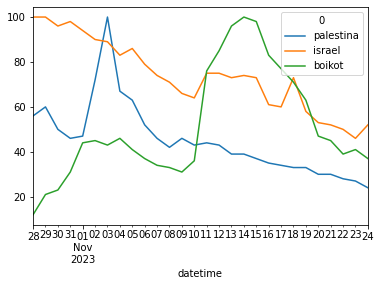

In [223]:
trends.plot()